In [1]:
import numpy as np
import pandas as pd
import math
import re
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy
from scipy import stats
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

### Load Data

In [2]:
df_bucket = pd.read_csv('bucket_model_result.csv') #bucket using probability
df_bucket_comm = pd.read_csv('bucket_committee_model_result.csv') #bucket using committee

### Data Preprocessing

In [3]:
feat_lst = ['model_name', 'balance', 'sort_by_time', 'learning_strategy', 'partition_ratio', 'sampling_size']
metric_lst_b = ['accuracy', 'f1_score', 'precision', 'recall', 'specificity']
bucket_col = feat_lst + metric_lst_b
strategies = ['probability', 'committee']
bucket_diff_col = ['accuracy_diff_probability', 'f1_score_diff_probability', 'precision_diff_probability', 'recall_diff_probability', 'specificity_diff_probability',
                             'accuracy_diff_committee', 'f1_score_diff_committee', 'precision_diff_committee', 'recall_diff_committee', 'specificity_diff_committee']

In [4]:
def assign_learning_strategy_prob(x):
    if x == 'random_sampling':
        return 'random_sampling_probability'
    else:
        return 'active_learning_probability'
    
def assign_learning_strategy_comm(x):
    if x == 'random_sampling':
        return 'random_sampling_committee'
    else:
        return 'active_learning_committee'

In [5]:
df_bucket['learning_strategy'] = df_bucket['training_method'].apply(assign_learning_strategy_prob)
df_bucket_comm['learning_strategy'] = df_bucket_comm['training_method'].apply(assign_learning_strategy_comm)
df_bucket = df_bucket[bucket_col]
df_bucket_comm=df_bucket_comm.rename(columns={"model_names": "model_name"})[bucket_col]
bucket = pd.concat([df_bucket, df_bucket_comm])

#### Create pivot table

In [6]:
bucket_pivot = bucket.pivot_table(metric_lst_b, ['model_name', 'balance', 'sort_by_time', 'partition_ratio', 'sampling_size'], 'learning_strategy')
bucket_pivot = bucket_pivot.reset_index()
bucket_pivot.columns = [bucket_pivot.columns.values[i][0] if i < 5 else '_'.join(bucket_pivot.columns.values[i]) for i in range(len(bucket_pivot.columns.values))]

for m in metric_lst_b:
    for s in strategies:
        diff_col = m + '_diff_' + s 
        al_col, rs_col = m + '_active_learning_' + s, m + '_random_sampling_' + s
        bucket_pivot[diff_col] = bucket_pivot[al_col] - bucket_pivot[rs_col]
        
bucket_stats = bucket_pivot[[f for f in feat_lst if f != 'learning_strategy'] + bucket_diff_col]

<AxesSubplot:>

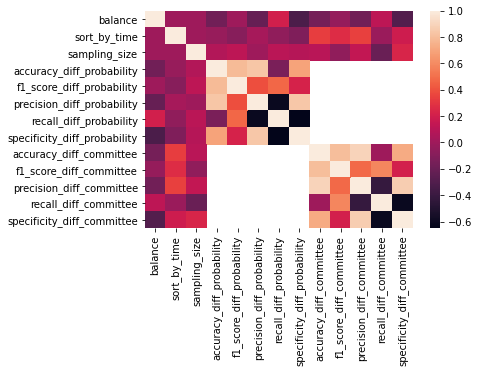

In [7]:
bucket_corr_plot=sns.heatmap(bucket_stats.corr())
bucket_corr_plot

In [8]:
# sns.pairplot(bucket_stats)

### Measure the effect of Active Learning (One Tailed Paired T-test)

#### Assumptions

As a parametric procedure (a procedure which estimates unknown parameters), the paired sample t-test makes several assumptions. Although t-tests are quite robust, it is good practice to evaluate the degree of deviation from these assumptions in order to assess the quality of the results. In a paired sample t-test, the observations are defined as the differences between two sets of values, and each assumption refers to these differences, not the original data values. The paired sample t-test has four main assumptions:

- The dependent variable must be continuous (interval/ratio).
- The observations are independent of one another.
- The dependent variable should be approximately normally distributed.
- The dependent variable should not contain any outliers.

**Level of Measurement**

The paired sample t-test requires the sample data to be numeric and continuous, as it is based on the normal distribution. Continuous data can take on any value within a range (income, height, weight, etc.). The opposite of continuous data is discrete data, which can only take on a few values (Low, Medium, High, etc.). Occasionally, discrete data can be used to approximate a continuous scale, such as with Likert-type scales.

**Independence**

Independence of observations is usually not testable, but can be reasonably assumed if the data collection process was random without replacement. In our example, it is reasonable to assume that the participating employees are independent of one another.

**Normality**

To test the assumption of normality, a variety of methods are available, but the simplest is to inspect the data visually using a tool like a histogram. Real-world data are almost never perfectly normal, so this assumption can be considered reasonably met if the shape looks approximately symmetric and bell-shaped. The data in the example figure below is approximately normally distributed.

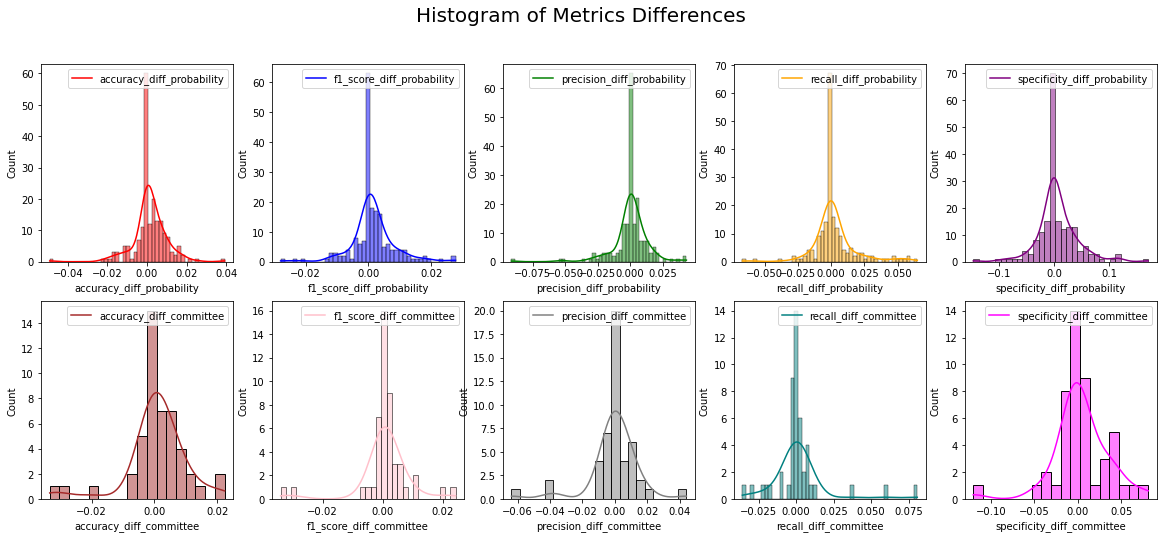

In [9]:
def plot_dist(df, df_col, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'teal', 'magenta', 'cyan', 'black', 
              'maroon', 'teal', 'olive', 'salmon', 'gold', 'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'teal', 'magenta', 'cyan', 'black']  
    row, col = 0, 0
    for i in range(len(df_col)):
        x = df_col[i]
        c = colors[i]
        sns.histplot(data=df, x=x, kde=True, color=c, alpha=0.5, ax=axes[row, col])
        axes[row, col].legend(labels=[x])
        if col < (ncols - 1):
            col += 1
        else:
            row += 1
            col = 0
    fig.suptitle('Histogram of Metrics Differences', fontsize=20)
    plt.show()
    
plot_dist(bucket_stats, bucket_diff_col, 2, 5, (20, 8))

**Outliers**

Outliers are rare values that appear far away from the majority of the data. Outliers can bias the results and potentially lead to incorrect conclusions if not handled properly. One method for dealing with outliers is to simply remove them. However, removing data points can introduce other types of bias into the results, and potentially result in losing critical information. If outliers seem to have a lot of influence on the results, a nonparametric test such as the Wilcoxon Signed Rank Test may be appropriate to use instead. Outliers can be identified visually using a boxplot.

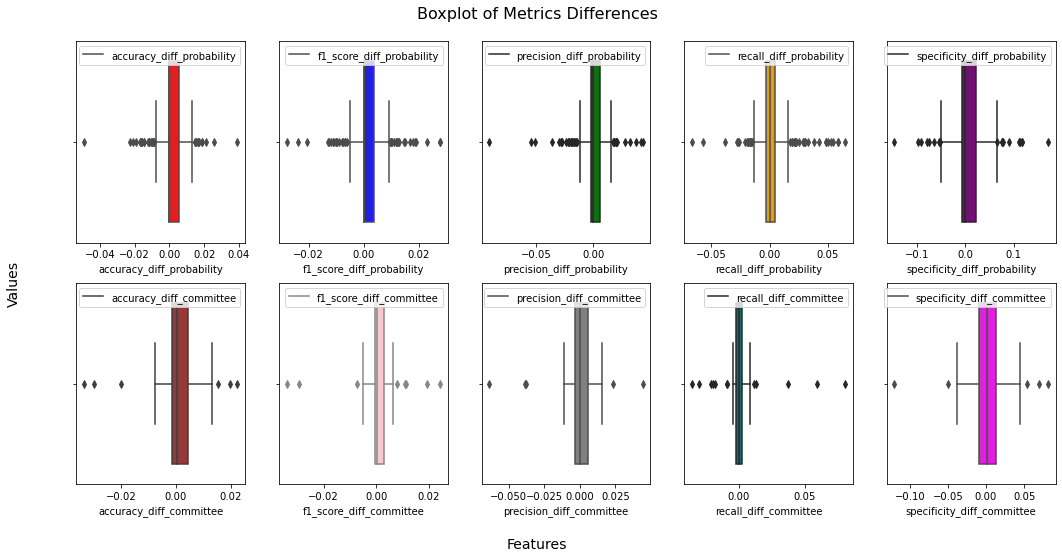

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 8))
sns.boxplot(data=bucket_stats, x='accuracy_diff_probability', color='red', ax=axes[0, 0])
sns.boxplot(data=bucket_stats, x='f1_score_diff_probability', color='blue', ax=axes[0, 1])
sns.boxplot(data=bucket_stats, x='precision_diff_probability', color='green', ax=axes[0, 2])
sns.boxplot(data=bucket_stats, x='recall_diff_probability', color='orange', ax=axes[0, 3])
sns.boxplot(data=bucket_stats, x='specificity_diff_probability', color='purple', ax=axes[0, 4])
sns.boxplot(data=bucket_stats, x='accuracy_diff_committee', color='brown', ax=axes[1, 0])
sns.boxplot(data=bucket_stats, x='f1_score_diff_committee', color='pink', ax=axes[1, 1])
sns.boxplot(data=bucket_stats, x='precision_diff_committee', color='gray', ax=axes[1, 2])
sns.boxplot(data=bucket_stats, x='recall_diff_committee', color='teal', ax=axes[1, 3])
sns.boxplot(data=bucket_stats, x='specificity_diff_committee', color='magenta', ax=axes[1, 4])
axes[0, 0].legend(labels=['accuracy_diff_probability'])
axes[0, 1].legend(labels=['f1_score_diff_probability'])
axes[0, 2].legend(labels=['precision_diff_probability'])
axes[0, 3].legend(labels=['recall_diff_probability'])
axes[0, 4].legend(labels=['specificity_diff_probability'])
axes[1, 0].legend(labels=['accuracy_diff_committee'])
axes[1, 1].legend(labels=['f1_score_diff_committee'])
axes[1, 2].legend(labels=['precision_diff_committee'])
axes[1, 3].legend(labels=['recall_diff_committee'])
axes[1, 4].legend(labels=['specificity_diff_committee'])
fig.suptitle('Boxplot of Metrics Differences', fontsize=16)
fig.text(0.5, 0.04, 'Features', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Values', va='center', rotation='vertical', fontsize=14)
plt.subplots_adjust(top=0.92, bottom=0.15, left=0.1, right=0.95, hspace=0.2, wspace=0.2)
plt.show()

#### Paired T-Test: Random Sampling vs Active Learning (Probability)

- Null Hypothesis (H0): There is no difference in the accuracy mean between random sampling and active learning (probability).

- (Upper-tailed) Alternative Hypothesis (H1): The mean accuracy of active learning (probability) is greater than the mean accuracy of random sampling. 

In [11]:
rsp = bucket[bucket['learning_strategy'] == 'random_sampling_probability']
alp = bucket[bucket['learning_strategy'] == 'active_learning_probability']

In [12]:
metrics = ['accuracy', 'f1_score', 'precision', 'recall', 'specificity']
def one_side_paired_t_test(random_sampling, active_learning):
    mean_lst, std_lst, se_mean_lst, low_95_lst, df_lst, t_stats_lst, p_value_lst = [],[],[],[],[],[],[]
    for m in metrics:
        rs_m, al_m = random_sampling[m], active_learning[m]
        m = stats.ttest_rel(al_m, rs_m, alternative='greater')
        diff = np.array(al_m) - np.array(rs_m)
        mean, std, sem = np.mean(diff), np.std(diff), stats.sem(diff)
        low_95, df, t_stats, p_value = m.confidence_interval().low, m.df, m.statistic, m.pvalue
        mean_lst.append(mean)
        std_lst.append(std)
        se_mean_lst.append(sem)
        low_95_lst.append(low_95)
        df_lst.append(df)
        t_stats_lst.append(t_stats)
        p_value_lst.append(p_value)
        
    summary_stats = {'Mean': mean_lst,
                     'Standard Deviation': std_lst,
                     'Standard Error Mean': se_mean_lst,
                     'Lower Bound (95% Confidence Interval)': low_95_lst,
                     'Degree of Freedom': df_lst,
                     'T-Statistic': t_stats_lst,
                     'P-Value': p_value_lst
    }
    
    pair_t_df = pd.DataFrame(data=summary_stats, index=metrics)
    return pair_t_df

In [13]:
prob_pair_t = one_side_paired_t_test(rsp, alp)

In [14]:
prob_pair_t

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.001467,0.008720,0.000631,0.000424,191,2.324599,0.010572
f1_score,0.001456,0.007008,0.000507,0.000618,191,2.871640,0.002272
precision,0.000226,0.014074,0.001018,-0.001457,191,0.221966,0.412289
recall,0.002544,0.016701,0.001208,0.000546,191,2.104975,0.018301
specificity,0.005958,0.036909,0.002671,0.001544,191,2.231045,0.013421


#### Paired T-Test: Random Sampling vs Active Learning (Committee)

Null Hypothesis (H0): There is no difference in the accuracy mean between random sampling and active learning (Committee).

(Upper-tailed) Alternative Hypothesis (H1): The mean accuracy of active learning (Committee) is greater than the mean accuracy of random sampling.

In [15]:
rsc = bucket[bucket['learning_strategy'] == 'random_sampling_committee']
alc = bucket[bucket['learning_strategy'] == 'active_learning_committee']

In [16]:
comm_pair_t = one_side_paired_t_test(rsc, alc)

In [17]:
comm_pair_t

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.000779,0.009546,0.001392,-0.001557,47,0.559546,0.289223
f1_score,0.000792,0.008616,0.001257,-0.001317,47,0.629944,0.265891
precision,-0.000387,0.015298,0.002231,-0.004132,47,-0.173656,0.568559
recall,0.001825,0.017935,0.002616,-0.002565,47,0.697608,0.244430
specificity,0.003712,0.031145,0.004543,-0.003910,47,0.817185,0.208973


### Explore how different parameters affect the performance of Active Learning

The different settings include:
 - **Balance**: if the labels in the dataset are balanced
 - **Sort by time**: if the tweets are sorted by time
 - **Partition Ratio**: the ratio of training, unlabeled, testing data
 - **Sample Size**: number of instances drawn from the unlabeled pool

In [18]:
def plot_mean_diff(feat, row, col, fig, val):
    fig, axs = plt.subplots(row, col, figsize=fig)
    for v in val:
        subset = bucket_stats[bucket_stats[feat] == v]
        for i in range(5):
            sns.distplot(subset[[metrics[i] + '_diff_probability']], hist=False, kde=True, kde_kws={'linewidth': 2}, label=v, ax=axs[i])
    for i in range(len(axs.flat)):
        axs.flat[i].set(xlabel=metrics[i] + '_diff', ylabel='Density')
    # Move the legends outside the plot
    handles, labels = axs.flat[0].get_legend_handles_labels()
    fig.legend(handles, labels, prop={'size': 8}, title=feat.title(), loc='center right', bbox_to_anchor=(0.98, 0.5))
    fig.suptitle('Difference of Metrics Mean (Random Sampling vs. Active Learning)')
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

**Balance**

In [19]:
# Balanced
rsp_balanced = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['balance']==True)]
alp_balanced = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['balance']==True)]
prob_pair_t_balanced = one_side_paired_t_test(rsp_balanced, alp_balanced)
prob_pair_t_balanced

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,-0.000029,0.011213,0.001150,-0.001940,95,-0.025353,0.510087
f1_score,0.001465,0.009632,0.000988,-0.000177,95,1.482112,0.070810
precision,-0.002777,0.018508,0.001899,-0.005931,95,-1.462476,0.926544
recall,0.005998,0.022362,0.002294,0.002187,95,2.614269,0.005199
specificity,-0.006038,0.033159,0.003402,-0.011688,95,-1.774659,0.960421


In [20]:
# Inbalanced
rsp_inbalanced = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['balance']==False)]
alp_inbalanced = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['balance']==False)]
prob_pair_t_inbalanced = one_side_paired_t_test(rsp_inbalanced, alp_inbalanced)
prob_pair_t_inbalanced

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.002962,0.004675,0.000480,0.002166,95,6.176378,8.088054e-09
f1_score,0.001448,0.002339,0.000240,0.001049,95,6.033747,1.535538e-08
precision,0.003229,0.005964,0.000612,0.002213,95,5.277222,4.128126e-07
recall,-0.000910,0.005825,0.000598,-0.001903,95,-1.523464,9.345176e-01
specificity,0.017954,0.036568,0.003752,0.011722,95,4.785466,3.123507e-06


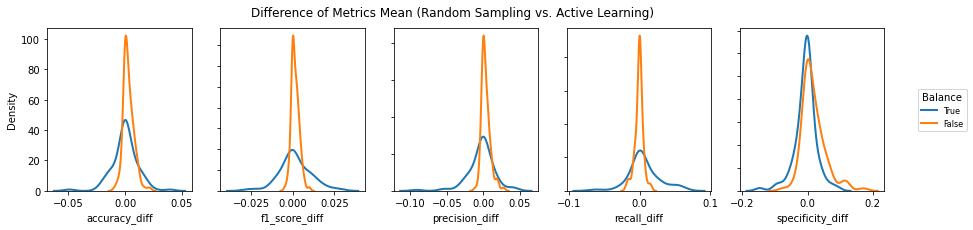

In [21]:
plot_mean_diff(feat='balance', row=1, col=5, fig=(15, 3), val=[True, False])

**Time**

In [22]:
# Sort by time
rsp_sort_by_time = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['sort_by_time']==True)]
alp_sort_by_time = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['sort_by_time']==True)]
prob_pair_t_sort_by_time = one_side_paired_t_test(rsp_sort_by_time, alp_sort_by_time)
prob_pair_t_sort_by_time

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.001215,0.008429,0.000865,-0.000222,95,1.404434,0.081725
f1_score,0.000867,0.006540,0.000671,-0.000248,95,1.291703,0.099797
precision,0.000688,0.011030,0.001132,-0.001192,95,0.607541,0.272471
recall,0.001608,0.016224,0.001665,-0.001157,95,0.966229,0.168192
specificity,0.001569,0.029634,0.003040,-0.003482,95,0.515965,0.303539


In [23]:
# Not Sort by time
rsp_not_sort_by_time = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['sort_by_time']==False)]
alp_not_sort_by_time = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['sort_by_time']==False)]
prob_pair_t_not_sort_by_time = one_side_paired_t_test(rsp_not_sort_by_time, alp_not_sort_by_time)
prob_pair_t_not_sort_by_time

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.001719,0.008994,0.000923,0.000186,95,1.862675,0.032799
f1_score,0.002046,0.007401,0.000759,0.000785,95,2.694259,0.004171
precision,-0.000235,0.016555,0.001699,-0.003057,95,-0.138599,0.554970
recall,0.003479,0.017114,0.001756,0.000563,95,1.981482,0.025214
specificity,0.010348,0.042519,0.004362,0.003102,95,2.372116,0.009851


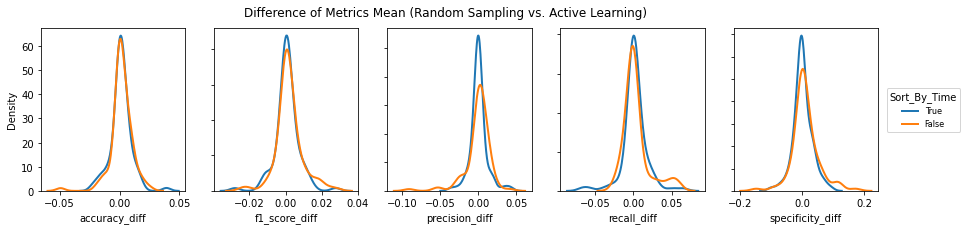

In [24]:
plot_mean_diff(feat='sort_by_time', row=1, col=5, fig=(15, 3), val=[True, False])

**Partition Ratio**

In [25]:
# Partition Ratio = [0.1, 0.45, 0.45]
rsp_145 = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['partition_ratio']=='[0.1, 0.45, 0.45]')]
alp_145 = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['partition_ratio']=='[0.1, 0.45, 0.45]')]
prob_pair_t_145 = one_side_paired_t_test(rsp_145, alp_145)
prob_pair_t_145

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.001572,0.010430,0.001314,-0.000622,63,1.196249,0.118041
f1_score,0.002619,0.008343,0.001051,0.000864,63,2.491298,0.007687
precision,-0.002313,0.019550,0.002463,-0.006424,63,-0.938891,0.824314
recall,0.007350,0.024663,0.003107,0.002163,63,2.365451,0.010549
specificity,0.005794,0.055372,0.006976,-0.005852,63,0.830497,0.204697


In [26]:
# Partition Ratio = [0.5, 0.25, 0.25]
rsp_525 = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['partition_ratio']=='[0.5, 0.25, 0.25]')]
alp_525 = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['partition_ratio']=='[0.5, 0.25, 0.25]')]
prob_pair_t_525 = one_side_paired_t_test(rsp_525, alp_525)
prob_pair_t_525

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,0.002956,0.005928,0.000747,0.001709,63,3.958354,0.000097
f1_score,0.001541,0.004328,0.000545,0.000630,63,2.825078,0.003162
precision,0.003662,0.008682,0.001094,0.001837,63,3.348435,0.000688
recall,-0.001547,0.009548,0.001203,-0.003555,63,-1.285963,0.898419
specificity,0.013663,0.022873,0.002882,0.008852,63,4.741055,0.000006


In [27]:
# Partition Ratio = [0.9, 0.05, 0.05]
rsp_905 = bucket[(bucket['learning_strategy'] == 'random_sampling_probability') & (bucket['partition_ratio']=='[0.9, 0.05, 0.05]')]
alp_905 = bucket[(bucket['learning_strategy'] == 'active_learning_probability') & (bucket['partition_ratio']=='[0.9, 0.05, 0.05]')]
prob_pair_t_905 = one_side_paired_t_test(rsp_905, alp_905)
prob_pair_t_905

,Mean,Standard Deviation,Standard Error Mean,Lower Bound (95% Confidence Interval),Degree of Freedom,T-Statistic,P-Value
accuracy,-0.000128,0.008911,0.001123,-0.002002,63,-0.114122,0.545248
f1_score,0.000209,0.007490,0.000944,-0.001366,63,0.221887,0.412560
precision,-0.000672,0.010845,0.001366,-0.002953,63,-0.491719,0.687687
recall,0.001828,0.009850,0.001241,-0.000244,63,1.473175,0.072841
specificity,-0.001581,0.019528,0.002460,-0.005689,63,-0.642702,0.738625


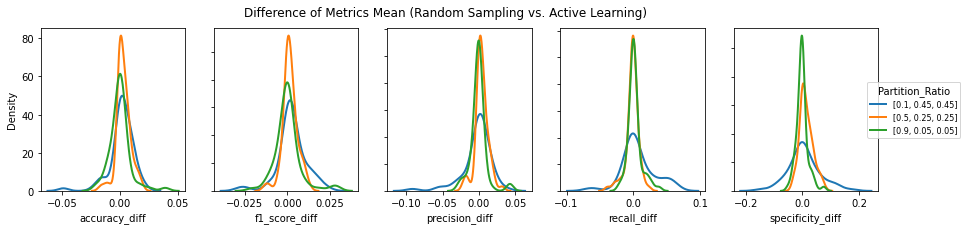

In [28]:
plot_mean_diff(feat='partition_ratio', row=1, col=5, fig=(15, 3), val=['[0.1, 0.45, 0.45]', '[0.5, 0.25, 0.25]', '[0.9, 0.05, 0.05]'])

#### Sample Size

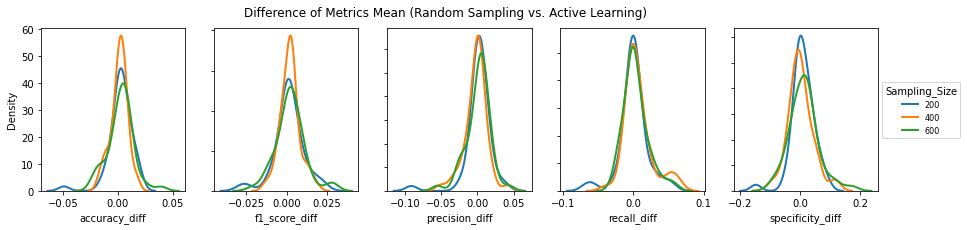

In [29]:
plot_mean_diff(feat='sampling_size', row=1, col=5, fig=(15, 3), val=[200, 400, 600])

### Choose best settings for Active Learning

In [30]:
def plot_subset(df, row, col, figsize, x, hue):
    # Create grid of subplots
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=figsize)
    # Loop through subplots and create line plots
    hue_colors = {}
    for i, ax in enumerate(axes):
        y = metrics[i]+"_diff_probability"
        sns.lineplot(data=df, x=x, y=y, hue=hue, ax=ax,legend=False)
        ax.set_title(y)
        if i == 0:
            for line, name in zip(ax.lines, df[hue].unique()):
                hue_colors[name] = line.get_color()        

    # Create legend on the side
    handles = [plt.Line2D([0,0],[0,0],color=hue_colors[key]) for key in hue_colors]
    labels = list(hue_colors.keys())
    fig.legend(handles, labels, prop={'size': 8}, title=hue, loc='center right', bbox_to_anchor=(1.1, 0.5))

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axes.flat:
        ax.label_outer()

    # Adjust spacing between subplots and display final plot
    plt.tight_layout()
    plt.show()

**Use Inbalanced data**

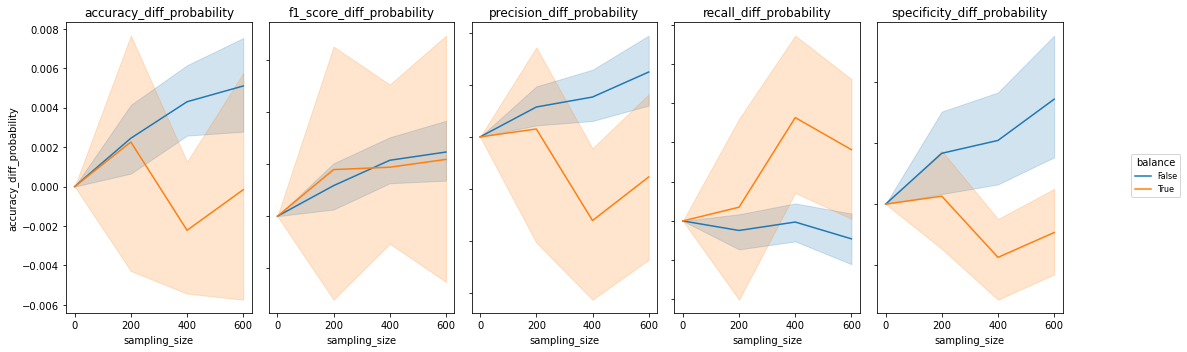

In [31]:
plot_subset(df=bucket_stats, row=1, col=5, figsize=(15,5), x="sampling_size", hue="balance")

**Use not sort by time data**

In [32]:
bucket_stats_inb = bucket_stats[bucket_stats['balance'] == False]

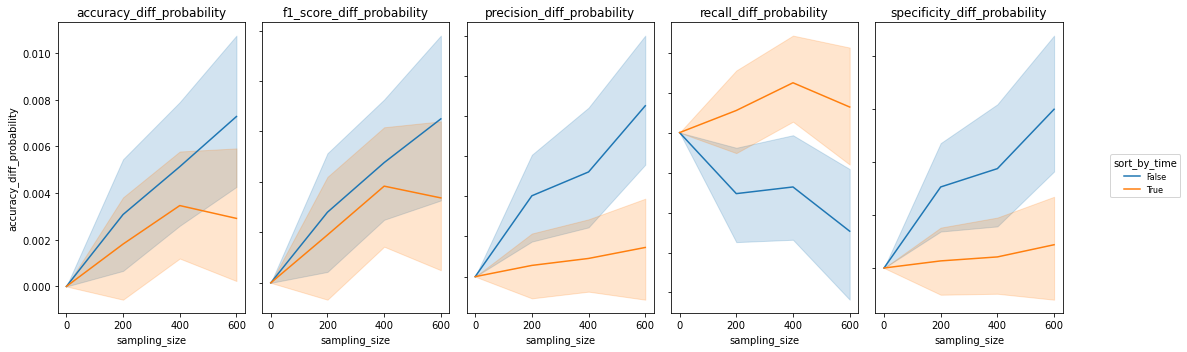

In [33]:
plot_subset(df=bucket_stats_inb, row=1, col=5, figsize=(15,5), x="sampling_size", hue="sort_by_time")

In [34]:
bucket_stats_inb_nst = bucket_stats_inb[bucket_stats_inb['sort_by_time'] == False]

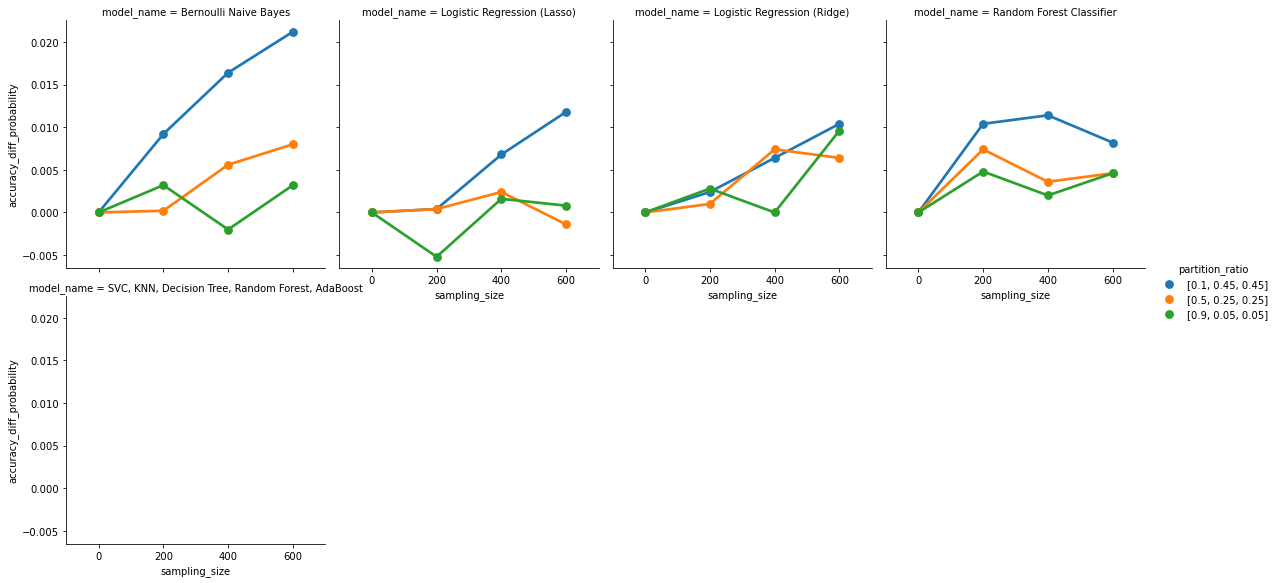

In [35]:
sns.catplot(
    x='sampling_size', 
    y='accuracy_diff_probability', 
    data=bucket_stats_inb_nst, 
    ci=None,  
    height=4,
    aspect=1,
    kind='point',
    hue='partition_ratio', 
    col='model_name', 
    col_wrap=4);

### Accuracy

In [39]:
bucket.sort_values(by=['accuracy'], ascending=False).head(10).reset_index(drop=True) #More data, better result

,model_name,balance,sort_by_time,learning_strategy,partition_ratio,sampling_size,accuracy,f1_score,precision,recall,specificity
0,Random Forest Classifier,False,False,active_learning_probability,"[0.9, 0.05, 0.05]",600,0.8610,0.9180,0.8600,0.9850,0.3750
1,Random Forest Classifier,False,False,active_learning_probability,"[0.9, 0.05, 0.05]",0,0.8610,0.9180,0.8580,0.9880,0.3650
2,Random Forest Classifier,False,False,random_sampling_probability,"[0.9, 0.05, 0.05]",0,0.8610,0.9180,0.8580,0.9880,0.3650
3,Random Forest Classifier,False,False,active_learning_probability,"[0.9, 0.05, 0.05]",400,0.8570,0.9170,0.8520,0.9930,0.3270
4,Random Forest Classifier,False,False,random_sampling_probability,"[0.9, 0.05, 0.05]",600,0.8564,0.9162,0.8536,0.9888,0.3404
5,Logistic Regression (Ridge),False,False,random_sampling_probability,"[0.9, 0.05, 0.05]",400,0.8550,0.9116,0.8828,0.9422,0.5136
6,Logistic Regression (Ridge),False,False,active_learning_probability,"[0.9, 0.05, 0.05]",400,0.8550,0.9120,0.8820,0.9430,0.5100
7,Logistic Regression (Ridge),False,True,active_learning_probability,"[0.9, 0.05, 0.05]",0,0.8550,0.9150,0.8590,0.9780,0.3750
8,Random Forest Classifier,False,False,active_learning_probability,"[0.9, 0.05, 0.05]",200,0.8550,0.9150,0.8530,0.9880,0.3370
9,Logistic Regression (Ridge),False,True,random_sampling_probability,"[0.9, 0.05, 0.05]",0,0.8550,0.9150,0.8590,0.9780,0.3750


In [40]:
bucket_stats.sort_values(by=['accuracy_diff_probability'], ascending=False).head(10).reset_index(drop=True) #More data, better result

,model_name,balance,sort_by_time,partition_ratio,sampling_size,accuracy_diff_probability,f1_score_diff_probability,precision_diff_probability,recall_diff_probability,specificity_diff_probability,accuracy_diff_committee,f1_score_diff_committee,precision_diff_committee,recall_diff_committee,specificity_diff_committee
0,Logistic Regression (Lasso),True,True,"[0.9, 0.05, 0.05]",600,0.0392,0.0278,0.0432,0.0036,0.0750,NaN,NaN,NaN,NaN,NaN
1,Bernoulli Naive Bayes,True,False,"[0.9, 0.05, 0.05]",600,0.0254,0.0278,0.0172,0.0384,0.0112,NaN,NaN,NaN,NaN,NaN
2,Bernoulli Naive Bayes,False,False,"[0.1, 0.45, 0.45]",600,0.0212,0.0098,0.0274,-0.0170,0.1710,NaN,NaN,NaN,NaN,NaN
3,Logistic Regression (Lasso),True,False,"[0.1, 0.45, 0.45]",200,0.0186,0.0232,0.0134,0.0300,0.0062,NaN,NaN,NaN,NaN,NaN
4,Random Forest Classifier,True,True,"[0.5, 0.25, 0.25]",200,0.0186,0.0076,0.0318,-0.0270,0.0644,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression (Lasso),True,False,"[0.9, 0.05, 0.05]",400,0.0168,0.0120,0.0418,-0.0114,0.0462,NaN,NaN,NaN,NaN,NaN
6,Random Forest Classifier,True,False,"[0.9, 0.05, 0.05]",200,0.0166,0.0186,0.0078,0.0286,0.0042,NaN,NaN,NaN,NaN,NaN
7,Logistic Regression (Ridge),True,True,"[0.5, 0.25, 0.25]",200,0.0164,0.0124,0.0140,0.0104,0.0222,NaN,NaN,NaN,NaN,NaN
8,Bernoulli Naive Bayes,False,False,"[0.1, 0.45, 0.45]",400,0.0164,0.0070,0.0178,-0.0094,0.1142,NaN,NaN,NaN,NaN,NaN
9,Bernoulli Naive Bayes,True,True,"[0.1, 0.45, 0.45]",200,0.0156,0.0096,0.0200,-0.0046,0.0364,NaN,NaN,NaN,NaN,NaN
